In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from opt import generate_exclusion_list
from theano import tensor as T

/anaconda2/envs/compgen/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
proc_data = pd.read_pickle('data/exp1_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(proc_data, training_contexts=5, goal_chance=1/3.)
for e in excluded:
    proc_data = proc_data[proc_data.subj != e]


100%|██████████| 149/149 [01:11<00:00,  2.00it/s]


# Analyses

In [3]:
uids = list(set(proc_data.subj))
proc_data['Accuracy'] = proc_data['Reward'] / 10.0
proc_data['Training'] = proc_data.loc[:, 'Context'] < 6

Below, we plot the training data as a check that subjects learned the task

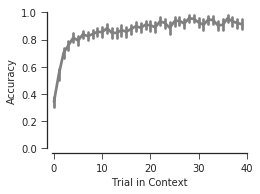

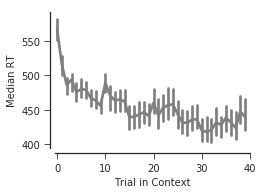

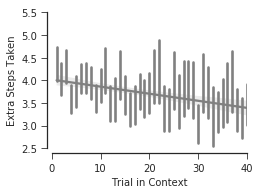

In [4]:
import scipy.stats
color = 'grey'
figsize = (3.5, 2.5)

with sns.axes_style('ticks'):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='Accuracy', 
                  data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                  ax=ax, markers=' ', color=color)
    lb, ub = ax.get_xlim()
    lb, ub = int(lb), int(ub)
    step = 10
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([0, 1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='rt', data=proc_data[proc_data['Training']], 
                  estimator=np.median, ax=ax,  markers=' ', color=color)
    ax.set_ylabel('Median RT')
    ax.set_xlabel('Trial in Context')
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.regplot(x='Times Seen Context', y='Normalized Steps Taken',
                x_estimator=np.mean,
                data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                truncate=True,
                ax=ax, marker= ' ', color=color)
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([2.5, 5.5])
    ax.set_xlim([lb, ub+1])
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylabel('Extra Steps Taken')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)

In [8]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii
n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_train_acc:
    
    a = pm.Normal('alpha', mu=0., sd=100**2)
    
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100**2)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100**2)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100**2)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(a + b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_train_acc = pm.sample()
    
pm.stats.summary(trace_train_acc, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times, alpha]
100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]
The acceptance probability does not match the target. It is 0.8885624406642776, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.108511,0.004836,0.000187,0.099918,0.119219,733.0,0.999106
beta_reps,1.103859,0.058327,0.001863,0.997351,1.219374,1000.0,0.999151


In [9]:
y = np.array(1. / X0['rt'].values)
y = (y - y.mean()) / y.std()

with pm.Model() as glm_rt:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100**2)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100**2)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100**2)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat =  b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    # inference
    trace_rt = pm.sample()
    
pm.stats.summary(trace_train_acc, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 1000/1000 [00:57<00:00, 17.53it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.108511,0.004836,0.000187,0.099918,0.119219,733.0,0.999106
beta_reps,1.103859,0.058327,0.001863,0.997351,1.219374,1000.0,0.999151


In [10]:
y = np.array(X0['Normalized Steps Taken'].values)

with pm.Model() as glm_steps:

    # define priors, weakly informative Normal
    b0 = pm.Normal('b0_intercept', mu=0, sd=10)
    b1 = pm.Normal('beta_times', mu=0, sd=10)
    b2 = pm.Normal('beta_reps', mu=0, sd=10)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100**2)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)

    # define linear model and exp link function
    theta = (b0 + a_sub[subj_idx] +
            b1 * x_ti+
            b2 * x_cr
            )

    ## Define Poisson likelihood
    y_hat = pm.Poisson('y', mu=np.exp(theta), observed=y)
    
    
    # inference
    trace_steps = pm.sample()
    
pm.stats.summary(trace_steps, varnames=['b0_intercept', 'beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times, b0_intercept]
100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]
The acceptance probability does not match the target. It is 0.9402292393607828, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0_intercept,0.856330,0.421249,0.042095,0.373575,1.406701,1.0,8.606003
beta_times,-0.003552,0.000372,0.000024,-0.004301,-0.002876,91.0,1.008867
beta_reps,-0.406622,0.009276,0.000535,-0.424121,-0.388937,143.0,0.999041


Here, we plot the differences scores for the test conditions across time. Thes are the a priori comparisons identified by the generative models

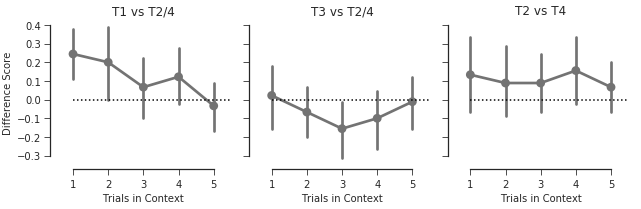

In [11]:
# plot the difference scores across time
df0 = df = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
                     (proc_data['Times Seen Context'] < 6)].copy()

score = list()

for uid in uids:
    subj_df = df0.loc[df0.subj == uid, :]

    if subj_df['Trial Number'].max() == df0['Trial Number'].max():

        grouped = subj_df.groupby(['Context', 'Times Seen Context']).mean()

        diff_1 = grouped.loc[6, 'Accuracy'] - 0.5 * (grouped.loc[7, 'Accuracy'] + \
                                                     grouped.loc[9, 'Accuracy'])
        diff_2 = grouped.loc[8, 'Accuracy'] - 0.5 * (grouped.loc[7, 'Accuracy'] + \
                                                     grouped.loc[9, 'Accuracy'])
        diff_3 = grouped.loc[7, 'Accuracy'] -  grouped.loc[9, 'Accuracy']
        diff_4 = grouped.loc[6, 'Accuracy'] -  grouped.loc[9, 'Accuracy']
        diff_5 = grouped.loc[8, 'Accuracy'] -  grouped.loc[7, 'Accuracy']


        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1 vs T2/4'] * n,
                    'Difference Score': diff_1,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T3 vs T2/4'] * n,
                    'Difference Score': diff_2,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T2 vs T4'] * n,
                    'Difference Score': diff_3,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_4,
                    'uniqueid': [uid] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_5,
                    'uniqueid': [uid] * n,
            }))

score = pd.concat(score)      
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1 vs T2/4'],  
                  ax=axes[0], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T3 vs T2/4'], 
                  ax=axes[1], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T2 vs T4'],  
                  ax=axes[2], color=[0.45, 0.45, 0.45])
    

    axes[0].set_xticklabels(range(1, 7))
    axes[0].set_ylabel('Difference Score')
    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    
    axes[0].set_title('T1 vs T2/4', fontdict={'size': 12})
    axes[1].set_title('T3 vs T2/4', fontdict={'size': 12})
    axes[2].set_title('T2 vs T4', fontdict={'size': 12})
    
    for ax in axes:
        ax.plot([0, 6], [0, 0], 'k:')
    
    plt.subplots_adjust(wspace=0.3)
    sns.despine(offset=5, trim=True)
    plt.tight_layout()


In [12]:
# run the bayesian GLM on the raw data

# create meaningful regressors
# really on only want to look at training
X0 = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
               (proc_data['Times Seen Context'] <= 5)].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 6, dtype=int) - \
     ((X0.Context.values == 7) | (X0.Context.values == 9))
    
x_2 = np.array(X0.Context.values == 8, dtype=int) - \
     ((X0.Context.values == 7) | (X0.Context.values == 9))
    
x_3 = np.array(X0.Context.values == 7, dtype=int) - \
     (X0.Context.values == 9)
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_1 = pm.Normal('beta_ctxT1vs24', mu=0., sd=100)
    b_2 = pm.Normal('beta_ctxT3vs24',  mu=0., sd=100)
    b_3 = pm.Normal('beta_ctxT2vs4',   mu=0., sd=100)
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100**2)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_1 * x_1 + b_2 * x_2 + b_3 * x_3 + \
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times, beta_ctxT2vs4, beta_ctxT3vs24, beta_ctxT1vs24]
100%|██████████| 1000/1000 [00:59<00:00, 16.74it/s]


In [13]:
summary = pm.stats.summary(trace, varnames=['beta_ctxT1vs24', 'beta_ctxT3vs24','beta_ctxT2vs4',
                                  'beta_times', 'beta_reps'])
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_ctxT1vs24,0.310897,0.079154,0.002111,0.163899,0.467707,1000.0,0.999081
beta_ctxT3vs24,-0.243147,0.073367,0.001893,-0.380259,-0.102256,1000.0,1.000535
beta_ctxT2vs4,0.075876,0.067252,0.001405,-0.053900,0.212397,1000.0,0.999196
beta_times,0.433165,0.038669,0.001883,0.362278,0.511783,343.0,0.999676
beta_reps,0.754567,0.142680,0.003548,0.494485,1.042744,1000.0,1.000319


In [14]:
# Compare model to a reduced model with out the contrasts
with pm.Model() as glm_reduced:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100**2)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_reduced = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 1000/1000 [00:49<00:00, 20.18it/s]


In [15]:
df_comp_LOO = pm.compare((trace, trace_reduced),
                          (glm, glm_reduced), ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Full', 'Reduced'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,warning
Full,2907.79,93.56,0,0.8,42.35,0,1
Reduced,2922.13,88.58,14.34,0.2,40.77,9.78,1


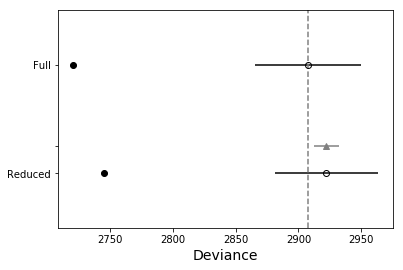

In [17]:
pm.compareplot(df_comp_LOO)

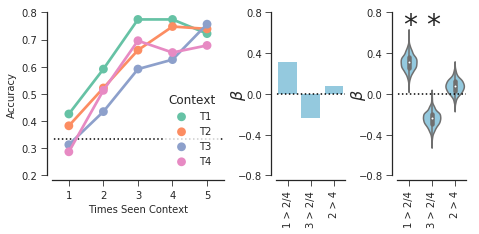

In [18]:
betas = pd.DataFrame({
        'T1vsT2/4': trace['beta_ctxT1vs24'],
        'T3vsT2/4': trace['beta_ctxT3vs24'],
        'T2vsT4':   trace['beta_ctxT2vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(7.43, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1, 1], wspace=0.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]))
    
    # show time series data as well
    df = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()
    
    ax=axes[0]
    sns.pointplot(x='Times Seen Context', y='Accuracy', hue='Context', #units='uniqueid',
                  estimator=np.mean, marker='.',
                        data=df[df['Times Seen Context'] < 6], palette='Set2', ax=ax, ci=None)

    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')

    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticklabels(range(1, 11))
    ax.set_ylabel('Accuracy')
    ax.plot([-1, 6], [1./3, 1./3], 'k:')
    ax.set_ylim([0.2, 0.8])
    sns.despine(offset=5)

    ax = axes[1]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=axes[1],
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[2]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2/4', 'T3vsT2/4', 'T2vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})
    
    for ii in range(1, 3):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2/4', u'3 > 2/4', r'2 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.8, -.4, 0, 0.4, 0.8])
        axes[ii].set_xlabel('')

    for ii, label in enumerate(['beta_ctxT1vs24', 'beta_ctxT3vs24','beta_ctxT2vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.22, 0.6), size=28)
